<h1 style = "text-align:center"> Cloud Computing and Big Data, Spring 2022</h1>
<h2 style = "text-align:center"> Assignment Report</h2>

<br>
<div style="text-align:center; border-style:solid; padding: 10px">
<div style="font-weight:bold"> Set Date: Friday, June 10, 2022</div>
<div style="font-weight:bold"> Due Date: 11:59pm, Friday, July 01, 2022</div>
<br>
This assignment counts for 30% of the final grade, along with 40% lab practical, and 30% final exam
<br>
Submit your completed Jupyter notebook file through the course website in the Blackboard Learn system
</div>


---

## Assignment Title:

## Student Name:Fan Li
## Student ID:320190940131

---

# Assignment Requirements

This assignment examines the level of knowledge the students have learned from the course. The assignment must be done on a cloud computing platform, for example, the Apache Spark platform.

#### Abstract
---
*(Briefly summarize the cloud-based assignment including the problem, data sets, models, evaluation, and final findings.)* 

### 1. Introduction
---
*(Introduce the assignment, describe the objectives, and present the results. This section will provide an overview of the entire assignment including the description of the data sets and the cloud-based data analytics methods and techniques the team used for analyzing the data to address the problem. Highlight the key findings.)*

### 2. Problem Definition
---
*(Define the problem that will be solved in this cloud computing assignment, what are the challenges of this problem?)*

#### 2.1. Initialization

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4MB 263kB/s 
     |████████████████████████████████| 204kB 41.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853643 sha256=51a9fc8d97aae6ee246a17a0faf7bf25475d005ae40da23d6928b99f7af6d314
  Stored in directory: /root/.cache/pip/wheels/23/35/61/f720c76ff25c680383cd010cd524fa66c91c9b62a4b0aebe9f
Successfully built pyspark


In [2]:
import os
import pandas as pd
import numpy as np
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### 2.2. Creating the Spark Session

In [3]:
spark = SparkSession.builder.master("local").appName("LR_housing").getOrCreate()
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/opt/conda/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


### 3. Data
---
*(Describe the origin, format, and  charateristics of the data. For example, where the data was obtained from, what data is contained in the set. The size of the dataset in terms of instances and features. What are the classes of the dataset)*
*(Cleanse, wrangle, transform, and analyze the data. Compute descriptive statistics and visualize the values of features and correlations between different features. Explain the process and the results.)*
#### 3.1. Understanding the Data Set
The California Housing data set appeared in a 1997 paper titled *Sparse Spatial Autoregressions*, written by Pace, R. Kelley and Ronald Barry and published in the Statistics and Probability Letters journal. The researchers built this data set by using the 1990 California census data.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

<p style="text-align: justify;"></p>
<pre><strong>Longitude:</strong>refers to the angular distance of a geographic place north or south of the earth’s equator for each block group
<strong>Latitude :</strong>refers to the angular distance of a geographic place east or west of the earth’s equator for each block group
<strong>Housing Median Age:</strong>is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values
<strong>Total Rooms:</strong>is the total number of rooms in the houses per block group
<strong>Total Bedrooms:</strong>is the total number of bedrooms in the houses per block group
<strong>Population:</strong>is the number of inhabitants of a block group
<strong>Households:</strong>refers to units of houses and their occupants per block group
<strong>Median Income:</strong>is used to register the median income of people that belong to a block group
<strong>Median House Value:</strong>is the dependent variable and refers to the median house value per block group
</pre>

What's more, we also learn that all the block groups have zero entries for the independent and dependent variables have been excluded from the data.

The Median house value is the dependent variable and will be assigned the role of the target variable in our ML model.

#### 3.2. Load The Data From a File Into a Dataframe

In [4]:
HOUSING_DATA = '../input/cal_housing.data'
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
housing_df = spark.read.csv(path=HOUSING_DATA, schema=schema).cache()
#Show first 5 rows
housing_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [5]:
housing_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



### 4. Exploratory Data Analysis
---


#### 4.1. Distribution of the median age of the people living in the area:

In [6]:
# run a sample selection
housing_df.select('pop','totbdrms').show(10)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows



In [7]:
# group by housingmedianage and see the distribution
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)

In [8]:
result_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



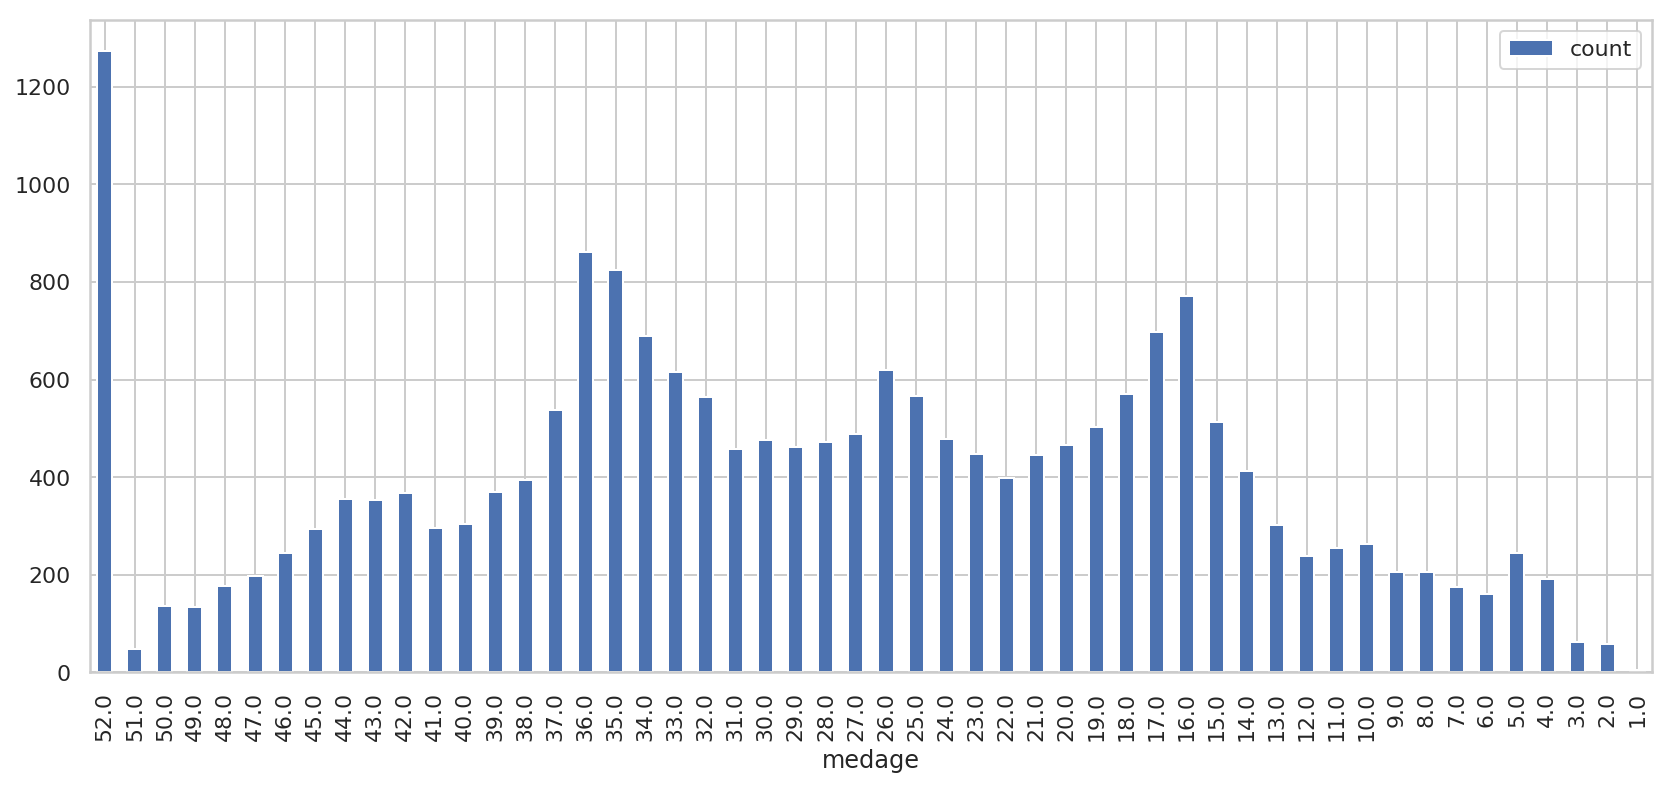

In [9]:
result_df.toPandas().plot.bar(x='medage',figsize=(14, 6))

Most of the residents are either in their youth or they settle here during their senior years. Some data are showing median age < 10 which seems to be out of place.

#### 4.2. Summary Statistics:

Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame.

In [10]:
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



#### 4.3. Data Preprocessing

To facilitate our working with the target values, we will express the house values in units of 100,000. That means that a target such as `452600.000000` should become `4.526`:

In [11]:
# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)

In [12]:
# Show the first 2 lines of `df`
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



#### 4.4. Feature Engineering
Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

+ Rooms per household which refers to the number of rooms in households per block group;
+ Population per household, which basically gives us an indication of how many people live in households per block group; And
+ Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;

As we're working with DataFrames, we can best use the `select()` method to select the columns that we're going to be working with, namely `totalRooms`, `households`, and `population`. Additionally, we have to indicate that we're working with columns by adding the `col()` function to our code. Otherwise, we won't be able to do element-wise operations like the division that we have in mind for these three variables:

In [13]:
# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

In [14]:
# Inspect the result
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



We can see that, for the first row, there are about 6.98 rooms per household, the households in the block group consist of about 2.5 people and the amount of bedrooms is quite low with 0.14:

Since we don’t want to necessarily standardize our target values, we’ll want to make sure to isolate those in our data set. Note also that this is the time to leave out variables that we might not want to consider in our analysis. In this case, let’s leave out variables such as longitude, latitude, housingMedianAge and totalRooms.
In this case, we will use the select() method and passing the column names in the order that is more appropriate. In this case, the target variable medianHouseValue is put first, so that it won’t be affected by the standardization.

In [15]:
# Re-order and select columns
housing_df = housing_df.select("medhv",
                              "totbdrms",
                              "pop",
                              "houshlds",
                              "medinc",
                              "rmsperhh",
                              "popperhh",
                              "bdrmsperrm")

#### 4.5. Feature Extraction

Now that we have re-ordered the data, we're ready to normalize the data. We will choose the features to be normalized.

In [16]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
assembled_df = assembler.transform(housing_df)
assembled_df.show(10, truncate=False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


All the features have transformed into a Dense Vector.

#### 4.6. Standardization

Next, we can finally scale the data using `StandardScaler`. The input columns are the `features`, and the output column with the rescaled that will be included in the scaled_df will be named `"features_scaled"`:

In [17]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

### 5. Modeling and Evaluation
---
*(Build analytic models and evaluate the models on the data. Provide detail on the data analytics process you have undertaken, e.g. data cleansing and preparation, feature selection, data modelling techniques and your rationale for selecting these.The analytics should be guided by the problem defined earlier. Explain the process and results along with code snippets. For the results, application of different methods and metrics for model evaluation. Visualization of results.)*

#### 5.1. Building A Machine Learning Model With Spark ML

With all the preprocessing done, it's finally time to start building our Linear Regression model! Just like always, we first need to split the data into training and test sets. Luckily, this is no issue with the `randomSplit()` method:

In [18]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2])

We pass in a list with two numbers that represent the size that we want your training and test sets to have and a seed, which is needed for reproducibility reasons.

In [19]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv',
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))
# Fit the data to the model
linearModel = lr.fit(train_data)

#### 5.2. Evaluating the Model

With our model in place, we can generate predictions for our test data: use the `transform()` method to predict the labels for our `test_data`. Then, we can use RDD operations to extract the predictions as well as the true labels from the DataFrame.

In [20]:
# Coefficients for the model
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5306, 0.0, 0.0, 0.0])

In [21]:
featureCols

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [22]:
# Intercept for the model
linearModel.intercept

0.9898492891444289

In [23]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]
coeff_df

,Feature,Co-efficients
0,Intercept,0.989849
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.530584
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


#### 5.3. Inspect the Metrics

Looking at predicted values is one thing, but another and better thing is looking at some metrics to get a better idea of how good your model actually is.

**Using the `LinearRegressionModel.summary` attribute:**

Next, we can also use the `summary` attribute to pull up the `rootMeanSquaredError` and the `r2`.

In [24]:
# Get the RMSE,MAE and R2
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))
print("R2: {0}".format(linearModel.summary.r2))

RMSE: 0.8797532139789227
MAE: 0.6772511725192225
R2: 0.423083655149444


+ The RMSE measures how much error there is between two datasets comparing a predicted value and an observed or known value. The smaller an RMSE value, the closer predicted and observed values are.

+ The R2 ("R squared") or the coefficient of determination is a measure that shows how close the data are to the fitted regression line. This score will always be between 0 and a 100% (or 0 to 1 in this case), where 0% indicates that the model explains none of the variability of the response data around its mean, and 100% indicates the opposite: it explains all the variability. That means that, in general, the higher the R-squared, the better the model fits our data.

In [25]:
#Stop the spark process
spark.stop()

### 6. Discussions and Conclusions
---
*(Provide a summary of the various results that you have obtained from the analysis and what these tell us. Briefly describe what you have done using cloud computing techniques and what you discovered. Discuss any shortcomings of the process and results. Propose future work. **Finally, discuss the lessons learned from doing the assignment**.)*

### 7. References